In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

import sys
sys.path.insert(0, '/home/563/esh563/TINT')

# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification_AURA as cl
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification_AURA
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

# %pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

In [4]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_base/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [3]:
base_dir = '/g/data/hj10/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/'
save_dir = '/home/563/esh563/TINT_tracks/'
fig_dir = '/home/563/esh563/TINT_figures/'
ERA5_dir = '/g/data/rt52/era5/pressure-levels/reanalysis/'

In [5]:
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset': 'dejavuserif'})
rcParams.update({'font.size': 12})

# Load Tracks

In [6]:
class_thresh = {
    'OFFSET_MAG': 5000,  # metres
    'SHEAR_MAG': 2,  # m/s
    'VEL_MAG': 5,  # m/s
    'REL_VEL_MAG': 2,  # m/s
    'ANGLE_BUFFER': 5}

excl_thresh = {
    'SMALL_AREA': 200,  # km^2
    'LARGE_AREA': 50000,  # km^2
    'BORD_THRESH': 0.001,  # Ratio border pixels to total pixels
    'MAJOR_AXIS_LENGTH': 25,  # km
    'AXIS_RATIO': 2,
    'DURATION': 30}  # minutes

exclusions = [
    'small_area', 'large_area', 'intersect_border',
    'intersect_border_convective', 'duration_cond',
    'small_velocity', 'small_offset']

In [7]:
tracks_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/national/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/national/'

In [314]:
included_radar = [
    2, 3, 4, 5, 6, 8, 9, 14, 16, 17,
    19, 22, 23, 24, 25, 27, 28, 29, 31, 32,
    33, 36, 37, 40, 41, 42, 44, 46, 48,
    49, 50, 52, 53, 54, 55, 56, 63, 64,
    66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77]

years = range(2012, 2024)

class_names = [
    'inflow_type', 'propagation_type', 'tilt_type', 
    'inflow_type', 'offset_type', 'rel_offset_type']
tracks_names = [
    'u_trop_shear', 'v_trop_shear', 'av_rh', 'av_rh_bfl', 'orientation', 
    'u_relative', 'v_relative', 'u_shift', 'v_shift', 'u_shear', 'v_shear', 'CAPE']
proxy_names = ['MLCAPE100', 'u06', 'v06', 'MUCAPE', 'MLCIN100']

data_names = ['radar', 'time'] + class_names + tracks_names + proxy_names

data_dic = dict(zip(data_names, [[] for i in range(len(data_names))]))

exclusions = [
    'small_area', 'large_area', 'intersect_border',
    'intersect_border_convective', 'duration_cond',
    'small_velocity', 'small_offset']

non_linear = False

for r in included_radar:
    print('Getting radar {}.'.format(r))
    for y in years:
        for m in range(1, 13):
            dir_ry = tracks_dir + '/radar_{}/{}/'.format(r, y)
            
            try:               
                filename = dir_ry + '/{:02}_{:04}_{:02}.pkl'.format(r, y, m)
                filename_proxies = dir_ry + '/{:02}_{:04}_{:02}_proxies.pkl'.format(r, y, m)
                with open(filename, 'rb') as f:
                    tracks_obj = pickle.load(f)
                with open(filename_proxies, 'rb') as f:
                    proxies = pickle.load(f)
            except FileNotFoundError:
                continue

            if len(tracks_obj.tracks) < 4:
                continue

            if exclusions is None:
                exclusions = [
                    'small_area', 'large_area', 'intersect_border',
                    'intersect_border_convective', 'duration_cond',
                    'small_velocity', 'small_offset']
            if non_linear:
                exclusions += ['non_linear']
            try:
                excluded = tracks_obj.exclusions[exclusions]
            except AttributeError:
                continue                
            amb = 'Ambiguous (On Quadrant Boundary)'
            quad_bound = tracks_obj.tracks_class['offset_type'] == amb
            excluded = np.logical_or(np.any(excluded, 1), quad_bound)
            included = np.logical_not(excluded)
                        
            sub_class = tracks_obj.tracks_class.where(included == True).dropna()
            sub_tracks = tracks_obj.tracks.fillna(-9999).where(included == True).dropna()
            sub_proxies = proxies.fillna(-9999).where(included.xs(0, level='level') == True).dropna()
            
            if len(sub_tracks) == 0:
                sub_tracks = None
            else:
                try:
                    sub_class = sub_class.xs(0, level='level')
                    sub_tracks = sub_tracks.xs(0, level='level')
                except KeyError:
                    sub_tracks = None
                    sub_class = None
            
            if sub_tracks is None:
                continue
            else:
#                 import pdb; pdb.set_trace()
                data_dic['radar'] += [r]*len(sub_tracks)
                data_dic['time'] += list(sub_tracks.index.get_level_values(1).values)
        
                if len(sub_proxies) != len(sub_class):
                    import pdb; pdb.set_trace()
                    print('Sizes do not match: skipping.')
        
                for n in class_names:
                    data_dic[n] += list(sub_class[n].values)
                for n in tracks_names:
                    data_dic[n] += list(sub_tracks[n].values)
                for n in proxy_names:
                    data_dic[n] += list(sub_proxies[n].replace(-9999, np.nan).values)

Getting radar 2.
Getting radar 3.
Getting radar 4.
Getting radar 5.
Getting radar 6.
Getting radar 8.
Getting radar 9.
Getting radar 14.
Getting radar 16.
Getting radar 17.
Getting radar 19.
Getting radar 22.
Getting radar 23.
Getting radar 24.
Getting radar 25.
Getting radar 27.
Getting radar 28.
Getting radar 29.
Getting radar 31.
Getting radar 32.
Getting radar 33.
Getting radar 36.
Getting radar 37.
Getting radar 40.
Getting radar 41.
Getting radar 42.
Getting radar 44.
Getting radar 46.
Getting radar 48.
Getting radar 49.
Getting radar 50.
Getting radar 52.
Getting radar 53.
Getting radar 54.
Getting radar 55.
Getting radar 56.
Getting radar 63.
Getting radar 64.
Getting radar 66.
Getting radar 67.
Getting radar 68.
Getting radar 69.
Getting radar 70.
Getting radar 71.
Getting radar 72.
Getting radar 73.
Getting radar 75.
Getting radar 76.
Getting radar 77.


In [75]:
data_dic.keys()

dict_keys(['radar', 'time', 'inflow_type', 'propagation_type', 'offset_type', 'rel_offset_type', 'u_trop_shear', 'v_trop_shear', 'av_rh', 'av_rh_bfl', 'orientation', 'u_relative', 'v_relative', 'u_shift', 'v_shift', 'u_shear', 'v_shear', 'CAPE', 'MLCAPE100', 'u06', 'v06', 'MUCAPE', 'MLCIN100'])

In [58]:
data_dic['CAPE']

[52.61995859240501,
 50.2191940121365,
 340.8721236385167,
 232.28132389766793,
 274.86751342604236,
 515.3349505262873,
 551.6055293329293,
 766.1015189518591,
 694.8797491361504,
 737.5090479530343,
 778.469626056828,
 350.4638766838746,
 323.2128257989881,
 324.2163098347746,
 271.95256363274916,
 68.44651182428146,
 57.81372630722509,
 53.300039004034204,
 40.66197379618063,
 25.15811472189712,
 34.26137680633143,
 326.4633727405859,
 324.8061131297219,
 281.60384954110265,
 331.7135738051907,
 431.8570105926701,
 0.0,
 0.0,
 0.0,
 0.08943286404867624,
 61.1248644367055,
 60.64026952723769,
 61.84932519750161,
 62.91635453972098,
 64.69977125860301,
 40.013176510974304,
 11.2647088171503,
 27.107188238321285,
 1054.8381968592623,
 1006.9865169844338,
 963.049425097934,
 1025.6674500681424,
 832.7121702883157,
 716.4739280198202,
 508.5549732704461,
 428.0466230343665,
 427.3661716856998,
 1052.9942113297534,
 987.3922572254326,
 998.1506935905596,
 928.0839323957355,
 958.035043382

In [351]:
delUsqrd = np.array(data_dic['u_trop_shear'])**2 + np.array(data_dic['v_trop_shear'])**2
R = np.array(data_dic['CAPE'])/(.5*delUsqrd)
av_rh = np.array(data_dic['av_rh'])
av_rh_bfl = np.array(data_dic['av_rh_bfl'])
CAPE = np.array(data_dic['CAPE'])
MLCAPE100 = np.array(data_dic['MLCAPE100'])
u06 = np.array(data_dic['u06'])
v06 = np.array(data_dic['v06'])
S06 = np.sqrt(u06**2+v06**2)

/tmp/ipykernel_13988/2288614099.py:12: RuntimeWarning: divide by zero encountered in log10
  np.log10(MLCAPE100), np.log10(S06), bins=[x_space, y_space],
/tmp/ipykernel_13988/2288614099.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(MLCAPE100), np.log10(S06), bins=[x_space, y_space],
/tmp/ipykernel_13988/2288614099.py:18: RuntimeWarning: divide by zero encountered in log10
  np.log10(MLCAPE100[rts_cond]), np.log10(S06[rts_cond]), bins=[x_space, y_space], cmap='Reds', density=True)
/tmp/ipykernel_13988/2288614099.py:18: RuntimeWarning: invalid value encountered in log10
  np.log10(MLCAPE100[rts_cond]), np.log10(S06[rts_cond]), bins=[x_space, y_space], cmap='Reds', density=True)
/tmp/ipykernel_13988/2288614099.py:25: RuntimeWarning: divide by zero encountered in log10
  np.log10(MLCAPE100[rls_cond]), np.log10(S06[rls_cond]), bins=[x_space, y_space], cmap='Reds', density=True)
/tmp/ipykernel_13988/2288614099.py:25: RuntimeWarning: invalid value encountered in log10
 

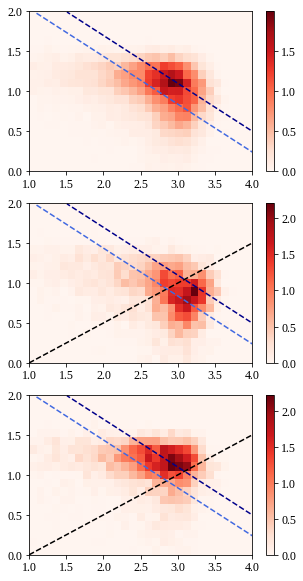

In [413]:
fig, ax = plt.subplots(3, 1, figsize=(5, 10))

y = np.arange(0, 2, 0.01)
xR = 2*y+1

xS = np.log10(25000)-1.67*y
xSS = np.log10(68000)-1.67*y

x_space = np.linspace(1, 4, 30)
y_space = np.linspace(0, 2, 20)
con0 = ax[0].hist2d(
    np.log10(MLCAPE100), np.log10(S06), bins=[x_space, y_space], 
    cmap='Reds', density=True)
ax[0].plot(xS, y, '--', color='royalblue')
ax[0].plot(xSS, y, '--', color='darkblue')
fig.colorbar(con0[3], ax=ax[0])
con1 = ax[1].hist2d(
    np.log10(MLCAPE100[rts_cond]), np.log10(S06[rts_cond]), bins=[x_space, y_space], cmap='Reds', density=True)
fig.colorbar(con1[3], ax=ax[1])
ax[1].plot(xR, y, '--k')
ax[1].plot(xS, y, '--', color='royalblue')
ax[1].plot(xSS, y, '--', color='darkblue')

con2 = ax[2].hist2d(
    np.log10(MLCAPE100[rls_cond]), np.log10(S06[rls_cond]), bins=[x_space, y_space], cmap='Reds', density=True)
ax[2].plot(xR, y, '--k')
ax[2].plot(xS, y, '--', color='royalblue')
ax[2].plot(xSS, y, '--', color='darkblue')
fig.colorbar(con2[3], ax=ax[2])
# plt.xscale('log')
# plt.yscale('log')

In [ ]:
x_space = np.linspace(1, 4, 30)
y_space = np.linspace(0, 2, 20)
plt.hist2d(
    np.log10(MLCAPE100), np.log10(S06), bins=[x_space, y_space], cmap='Reds', density=True)
# plt.xscale('log')
# plt.yscale('log')
plt.colorbar()

/tmp/ipykernel_13988/2332515051.py:4: RuntimeWarning: divide by zero encountered in log10
  np.log10(MLCAPE100[rls_cond]), np.log10(S06[rls_cond]), bins=[x_space, y_space], cmap='Reds', density=True)
/tmp/ipykernel_13988/2332515051.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(MLCAPE100[rls_cond]), np.log10(S06[rls_cond]), bins=[x_space, y_space], cmap='Reds', density=True)


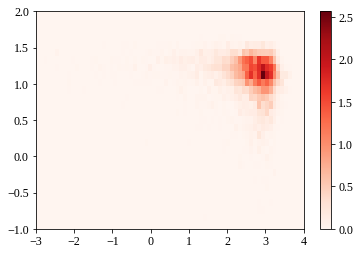

In [372]:
x_space = np.linspace(-3, 4, 70)
y_space = np.linspace(-1, 2, 30)
plt.hist2d(
    np.log10(MLCAPE100[rls_cond]), np.log10(S06[rls_cond]), bins=[x_space, y_space], cmap='Reds', density=True)
# plt.xscale('log')
# plt.yscale('log')
plt.colorbar()

In [ ]:
y_space = np.logspace(np.log10(1), np.log10(1e2), 20)
plt.scatter(MLCAPE100, S06, c='r')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

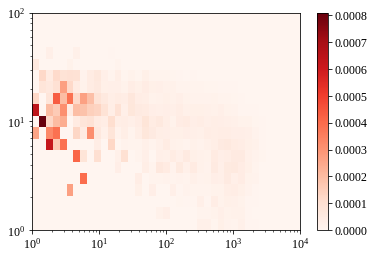

In [321]:
y_space = np.logspace(np.log10(1), np.log10(1e2), 20)
plt.hist2d(MLCAPE100[rts_cond], S06[rts_cond], bins=[x_space, y_space], cmap='Reds', density=True)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [352]:
rts_cond = np.array(data_dic['rel_offset_type']) == 'Relative Trailing Stratiform'
rls_cond = np.array(data_dic['rel_offset_type']) == 'Relative Leading Stratiform'
# ust_cond = np.array(data_dic['tilt_type']) == 'Up-Shear Tilted'
rles_cond = np.array(data_dic['rel_offset_type']) == 'Relative Parallel Stratiform (Left)'
rrs_cond = np.array(data_dic['rel_offset_type']) == 'Relative Parallel Stratiform (Right)'
rps_cond = np.logical_or(rles_cond, rrs_cond)

In [230]:
ust_cond = np.array(data_dic['tilt_type']) == 'Up-Shear Tilted'
dst_cond = np.array(data_dic['tilt_type']) == 'Down-Shear Tilted'

In [214]:
# len(R[rrs_cond])
len(R[rps_cond])

17133

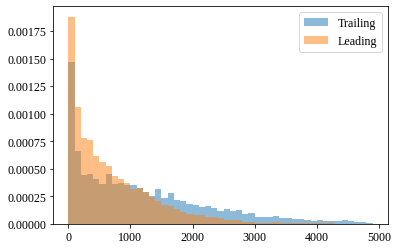

In [216]:
plt.hist(CAPE[rts_cond], bins=np.arange(0,5*1e3,100), alpha=.5, density=True, label = 'Trailing')
plt.hist(CAPE[rls_cond], bins=np.arange(0,5*1e3,100), alpha=.5, density=True, label = 'Leading')
plt.legend()

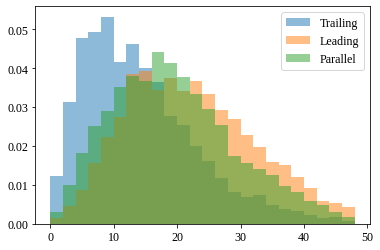

In [226]:
plt.hist(np.sqrt(delUsqrd)[rts_cond], bins=np.arange(0,50,2), alpha=.5, density=True, label = 'Trailing')
plt.hist(np.sqrt(delUsqrd)[rls_cond], bins=np.arange(0,50,2), alpha=.5, density=True, label = 'Leading')
plt.hist(np.sqrt(delUsqrd)[rps_cond], bins=np.arange(0,50,2), alpha=.5, density=True, label = 'Parallel')
plt.legend()

In [159]:
np.any(delUsqrd == 0)

False

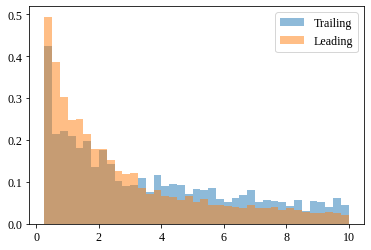

In [221]:
db = .25
plt.hist(R[rts_cond], bins=np.arange(db,10+db,db), alpha=.5, density=True, label = 'Trailing')
plt.hist(R[rls_cond], bins=np.arange(db,10+db,db), alpha=.5, density=True, label = 'Leading')
# plt.gca().set_xscale("log")
plt.legend()

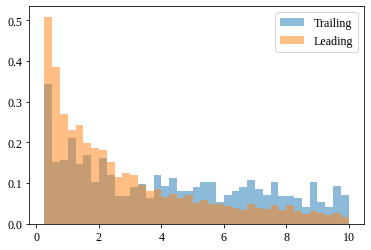

In [242]:
db = .25
plt.hist(R[np.logical_and(ust_cond, rts_cond)], bins=np.arange(db,10+db,db), alpha=.5, density=True, label = 'Trailing')
plt.hist(R[np.logical_and(dst_cond, rls_cond)], bins=np.arange(db,10+db,db), alpha=.5, density=True, label = 'Leading')
# plt.hist(R[rps_cond], bins=np.arange(db,10+db,db), alpha=.25, density=True, label = 'Parallel')
# plt.gca().set_xscale("log")
plt.legend()

(array([0.76211079, 0.33253496, 0.26578073, 0.2166422 , 0.17801128,
        0.15977749, 0.15359654, 0.14463417, 0.11960133, 0.1291818 ,
        0.11063896, 0.10167658, 0.0874604 , 0.08251565, 0.07911612,
        0.07108089, 0.07108089, 0.0704628 , 0.05964614, 0.0645909 ,
        0.06057328, 0.05130186, 0.04944758, 0.04326663, 0.04728425,
        0.03955806, 0.04666615, 0.03893997, 0.03924901, 0.03584949,
        0.03646759, 0.02812331, 0.03368616, 0.03739473, 0.03430426,
        0.03337712, 0.02225141, 0.0228695 , 0.02163332, 0.0176157 ]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
         2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
         4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
         6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
         9.  ,  9.25,  9.5 ,  9.75, 10.  ]),
 <BarContainer object of 40 artists>)

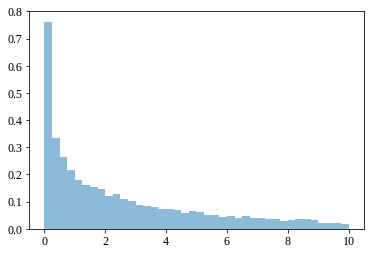

In [243]:
print(np.median(R[rls_cond]))
print(np.median(R[rts_cond]))
print(np.median(R[rps_cond]))

print(np.median(R[dst_cond]))
print(np.median(R[ust_cond]))

print(np.median(R[np.logical_and(dst_cond, rls_cond)]))
print(np.median(R[np.logical_and(ust_cond, rts_cond)]))

1.9199341894510518
11.234040838591564
2.857990174774171
2.208745732343901
14.640997479634098
1.9264213600860398
24.225392338667


In [10]:
cl.create_oper_radar_counts(
    save_dir, tracks_dir, class_thresh=None, excl_thresh=None,
    exclusions=None, non_linear_conds=False, morning_only=False)

Getting classes for radar 2, year 2012.
Processing year 2012, month 1, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 2, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 3, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 4, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 5, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 6, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 7, radar, 2
No tracks. Skipping
Processing year 2012, month 8, radar, 2
No

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 6, radar, 2
No tracks. Skipping
Processing year 2017, month 7, radar, 2
No tracks. Skipping
Processing year 2017, month 8, radar, 2
No tracks. Skipping
Processing year 2017, month 9, radar, 2
No tracks file. Skipping
Processing year 2017, month 10, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 11, radar, 2
Getting new exclu

Adding Pope monsoon regime.
Processing year 2021, month 12, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 2, year 2022.
Processing year 2022, month 1, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 3, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 6, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Pr

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 11, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 12, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 3, year 2016.
Processing year 2016, month 1, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 3, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
N

No tracks satisfying conditions. Skipping year.
Processing year 2020, month 9, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 10, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 11, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 3, year 2021.
Processing year 2021, month 1, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 3
Getting new exclusions.
Calculating 

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 9, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 10, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 11, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 12, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 4, year 2015.
Processing year 2015, month 1, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.


Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 9, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 10, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 11, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 12, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 4, year 2020.
Processing year 2020, month 1, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 2, radar, 4
Getting new exclusions.
Calculating system tracks.


Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 5, year 2014.
Processing year 2014, month 1, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 2, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 3, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 4, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 5, radar, 5
No tracks. Skipping
Processing year 2014, month 6, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 7, radar,

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 5, year 2019.
Processing year 2019, month 1, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 2, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 3, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 4, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 5, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 6, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, mont

Adding Pope monsoon regime.
Processing year 2012, month 6, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 7, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 8, radar, 6
No tracks. Skipping
Processing year 2012, month 9, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 10, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 11, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 12, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Get

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 6, year 2017.
Processing year 2017, month 1, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 2, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 3, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 6, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, mont

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 12, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 6, year 2022.
Processing year 2022, month 1, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 2, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 3, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 6
Getting new exclusions.
Calculating system tracks.
Addin

Adding Pope monsoon regime.
Processing year 2015, month 12, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 8, year 2016.
Processing year 2016, month 1, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 3, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 4, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 8
No tracks. Skipping
Processing year 2016, month 6, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks sat

Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 5, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 6, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 7, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 8, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 9, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 20

Processing year 2015, month 2, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 4, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 5, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 6, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 7, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 8, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, m

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 11, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 9, year 2021.
Processing year 2021, month 1, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 5, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime

No tracks satisfying conditions. Skipping year.
Processing year 2014, month 9, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 10, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 11, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 12, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 14, year 2015.
Processing year 2015, month 1, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 14
Get

Adding Pope monsoon regime.
Processing year 2019, month 5, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 6, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 7, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 8, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 9, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 10, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 11, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope mo

Adding Pope monsoon regime.
Getting classes for radar 16, year 2013.
Processing year 2013, month 1, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 2, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 3, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 4, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 5, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 6, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 7, radar, 16
No tracks. Skipping
Processing year 2013, month 8, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pop

Adding Pope monsoon regime.
Processing year 2017, month 12, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 16, year 2018.
Processing year 2018, month 1, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 4, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 5, radar, 16
No tracks. Skipping
Processing year 2018, month 6, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 7, radar, 16
No tracks. S

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 12, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 17, year 2012.
Processing year 2012, month 1, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 2, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 4, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 5, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 20

No tracks satisfying conditions. Skipping year.
Processing year 2016, month 7, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 8, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 9, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 10, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 11, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 12, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 17, year 20

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 17, year 2022.
Processing year 2022, month 1, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 3, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 6, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 

No tracks satisfying conditions. Skipping year.
Processing year 2016, month 12, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 19, year 2017.
Processing year 2017, month 1, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 2, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 3, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 6, radar, 19
Getti

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 19
No tracks. Skipping
Processing year 2022, month 9, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 10, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 11, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 12, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 22, year 2012.
Processing year 2012, month 1, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 2, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Pro

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 10, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 11, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 12, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 22, year 2017.
Processing year 2017, month 1, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 2, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar,

Adding Pope monsoon regime.
Processing year 2021, month 12, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 22, year 2022.
Processing year 2022, month 1, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 3, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 6, radar, 22
No tracks. Skipping
Processing year 2022, month 7, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Po

Processing year 2015, month 11, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 12, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 23, year 2016.
Processing year 2016, month 1, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 3, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying 

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 9, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 10, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 11, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 12, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 23, year 2021.
Processing year 2021, month 1, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 2, radar, 23
Getting new exclusions.
Calculating system trac

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 12, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 24, year 2015.
Processing year 2015, month 1, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 4, radar, 24
No tracks. Skipping
Processing year 2015, month 5, radar, 24
No tracks. Skipping
Processing year 2015, month 6, radar, 24
No tracks. Skipping
Processing year 2015, month 7, radar, 24
No tracks. Skipping
Processing year 2015, month 8, radar, 24
No tracks. Skipping
Processing year 2015, month 9, radar, 24
No track

No tracks. Skipping
Processing year 2020, month 7, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 8, radar, 24
No tracks. Skipping
Processing year 2020, month 9, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 10, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 11, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 24, year 2021.
Processing year 2021, month 1, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 24
Getting new exclus

Getting classes for radar 25, year 2015.
Processing year 2015, month 1, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 25
No tracks. Skipping
Processing year 2015, month 4, radar, 25
No tracks. Skipping
Processing year 2015, month 5, radar, 25
No tracks. Skipping
Processing year 2015, month 6, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 7, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 8, radar, 25
No tracks. Skipping
Processing year 2015, month 9, radar, 25
No tracks. Skipping
Processing year 2015, month 10, radar, 25
No tracks. Skipping
Processing year 

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 3, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 4, radar, 25
No tracks. Skipping
Processing year 2021, month 5, radar, 25
No tracks. Skipping
Processing year 2021, month 6, radar, 25
No tracks. Skipping
Processing year 2021, month 7, radar, 25
No tracks. Skipping
Processing year 2021, month 8, radar, 25
No tracks. Skipping
Processing year 2021, month 9, radar, 25
No tracks. Skipping
Processing year 2021, month 10, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 11, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 12, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 2

Processing year 2015, month 5, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 6, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 7, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 8, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 9, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 10, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 11, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing yea

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 27, year 2020.
Processing year 2020, month 1, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 2, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 3, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 4, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 5, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 6, radar, 27
Ge

Adding Pope monsoon regime.
Processing year 2013, month 10, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 11, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 12, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 28, year 2014.
Processing year 2014, month 1, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 2, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 3, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 4, radar, 28
Getting new exclusions.

Processing year 2018, month 11, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 28, year 2019.
Processing year 2019, month 1, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 2, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 3, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 4, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 5, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019,

Adding Pope monsoon regime.
Getting classes for radar 29, year 2013.
Processing year 2013, month 1, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 2, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 3, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 4, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 5, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 6, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 7, radar, 29
No tracks. Skipping
Processing year 2013, month 8, radar, 29
No tracks. Sk

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 11, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 12, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 29, year 2018.
Processing year 2018, month 1, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 4, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 4, radar, 31
No tracks. Skipping
Processing year 2012, month 5, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 6, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 7, radar, 31
No tracks. Skipping
Processing year 2012, month 8, radar, 31
No tracks. Skipping
Processing year 2012, month 9, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 10, radar, 31
No tracks. Skipping
Processing year 2012, month 11, radar, 31
No tracks. Sk

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 12, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 31, year 2019.
Processing year 2019, month 1, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 2, radar, 31
No tracks. Skipping
Processing year 2019, month 3, radar, 31
No tracks file. Skipping
Processing year 2019, month 4, radar, 31
No tracks file. Skipping
Processing year 2019, month 5, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 6, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 7, radar, 31
Getting new exclusions.


Adding Pope monsoon regime.
Getting classes for radar 32, year 2013.
Processing year 2013, month 1, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 2, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 3, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 4, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 5, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 6, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 7, radar, 32
Getting new exclusions.
Ca

Adding Pope monsoon regime.
Processing year 2017, month 10, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 11, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 12, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 32, year 2018.
Processing year 2018, month 1, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 

Processing year 2022, month 7, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 9, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 10, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 11, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 12, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 33, year 2012.
Processing year 2012, month 1, radar, 33
Get

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 2, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 4, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 33
No tracks. Skipping
Processing year 2017, month 6, radar, 33
No tracks. Skipping
Processing year 2017, month 7, radar, 33
No tracks. Skipping
Processing year 2017, month 8, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 9, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regim

Adding Pope monsoon regime.
Processing year 2022, month 10, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 11, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 12, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 36, year 2012.
Processing year 2012, month 1, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 2, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 4, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 5, radar, 36

Processing year 2017, month 11, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 12, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 36, year 2018.
Processing year 2018, month 1, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 4, radar, 36
No tracks. Skipping
Processing year 2018, month 5, radar, 36
No tracks. Skipping
Processing year 2018, month 6, radar, 36
No tracks. Skipping
Processing year 2018, month 7, radar, 36
No tracks. Skipping
Processing year 2

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 3, radar, 37
No tracks. Skipping
Processing year 2014, month 4, radar, 37
No tracks. Skipping
Processing year 2014, month 5, radar, 37
No tracks. Skipping
Processing year 2014, month 6, radar, 37
No tracks. Skipping
Processing year 2014, month 7, radar, 37
No tracks. Skipping
Processing year 2014, month 8, radar, 37
No tracks. Skipping
Processing year 2014, month 9, radar, 37
No tracks. Skipping
Processing year 2014, month 10, radar, 37
No tracks. Skipping
Processing year 2014, month 11, radar, 37
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 12, radar, 37
No tracks. Skipping
Getting classes for radar 37, year 2015.
Processing year 2015, month 1, radar, 37
No tracks. Skipping
Processing year 2015, month 2, radar, 37
No tracks. Skipping
Processing year 2015, month 3, radar, 37


Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 11, radar, 37
No tracks. Skipping
Processing year 2022, month 12, radar, 37
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 40, year 2012.
Processing year 2012, month 1, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 2, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 3, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 4, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 5, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
N

No tracks satisfying conditions. Skipping year.
Processing year 2016, month 6, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 7, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 8, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 9, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 10, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 11, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoo

Adding Pope monsoon regime.
Getting classes for radar 40, year 2021.
Processing year 2021, month 1, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 5, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 6, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 7, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon reg

Adding Pope monsoon regime.
Getting classes for radar 41, year 2016.
Processing year 2016, month 1, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 2, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 3, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 6, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfyin

No tracks. Skipping
Processing year 2021, month 9, radar, 41
No tracks. Skipping
Processing year 2021, month 10, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 11, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 12, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 41, year 2022.
Processing year 2022, month 1, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 3, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope mon

Adding Pope monsoon regime.
Processing year 2016, month 3, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 6, radar, 42
No tracks. Skipping
Processing year 2016, month 7, radar, 42
No tracks. Skipping
Processing year 2016, month 8, radar, 42
No tracks. Skipping
Processing year 2016, month 9, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 10, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 11, radar, 42
Getting new exclusions.
Calculating system tracks.

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 11, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 12, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 44, year 2012.
Processing year 2012, month 1, radar, 44
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 2, radar, 44
No tracks. Skipping
Processing year 2012, month 3, radar, 44
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 4, radar, 44
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 5, radar, 44
No tracks. Skipping
Processing y

No tracks satisfying conditions. Skipping year.
Getting classes for radar 44, year 2018.
Processing year 2018, month 1, radar, 44
No tracks. Skipping
Processing year 2018, month 2, radar, 44
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 3, radar, 44
No tracks. Skipping
Processing year 2018, month 4, radar, 44
No tracks. Skipping
Processing year 2018, month 5, radar, 44
No tracks. Skipping
Processing year 2018, month 6, radar, 44
No tracks. Skipping
Processing year 2018, month 7, radar, 44
No tracks file. Skipping
Processing year 2018, month 8, radar, 44
No tracks. Skipping
Processing year 2018, month 9, radar, 44
No tracks. Skipping
Processing year 2018, month 10, radar, 44
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 11, radar, 44
Getting new exclusions.
Calculating sys

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 4, radar, 46
No tracks. Skipping
Processing year 2013, month 5, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 6, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 7, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 8, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 9, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, m

No tracks satisfying conditions. Skipping year.
Processing year 2018, month 7, radar, 46
No tracks. Skipping
Processing year 2018, month 8, radar, 46
No tracks. Skipping
Processing year 2018, month 9, radar, 46
No tracks. Skipping
Processing year 2018, month 10, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 11, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 46, year 2019.
Processing year 2019, month 1, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 2, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditio

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 2, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 48
No tracks. Skipping
Processing year 2012, month 4, radar, 48
No tracks. Skipping
Processing year 2012, month 5, radar, 48
No tracks. Skipping
Processing year 2012, month 6, radar, 48
No tracks. Skipping
Processing year 2012, month 7, radar, 48
No tracks. Skipping
Processing year 2012, month 8, radar, 48
No tracks. Skipping
Processing year 2012, month 9, radar, 48
No tracks. Skipping
Processing year 2012, month 10, radar, 48
No tracks. Skipping
Processing year 2012, month 11, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 12, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying cond

Adding Pope monsoon regime.
Processing year 2017, month 11, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 12, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 48, year 2018.
Processing year 2018, month 1, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 4, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 5, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 6, radar, 48


No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 9, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 10, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 11, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 12, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 49, year 2012.
Processing year 2012, month 1, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regi

Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 6, radar, 49
No tracks. Skipping
Processing year 2017, month 7, radar, 49
No tracks. Skipping
Processing year 2017, month 8, radar, 49
No tracks. Skipping
Processing year 2017, month 9, radar, 49
No tracks. Skipping
Processing year 2017, month 10, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 11, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 12, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Po

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 4, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 49
No tracks. Skipping
Processing year 2022, month 6, radar, 49
No tracks. Skipping
Processing year 2022, month 7, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 9, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 10, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks

Adding Pope monsoon regime.
Processing year 2015, month 11, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 12, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 50, year 2016.
Processing year 2016, month 1, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 3, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 10, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 11, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 50, year 2021.
Processing year 2021, month 1, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 2, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon 

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 2, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 4, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 52
No tracks. Skipping
Processing year 2017, month 6, radar, 52
No tracks. Skipping
Processing year 2017, month 7, radar, 52
No tracks. Skipping
Processing year 2017, month 8, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 9, radar, 52
No tracks. Skipping
Processi

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 52, year 2022.
Processing year 2022, month 1, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 3, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 4, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 6, radar, 52
Getting new exclusions.
Calculating system tracks.

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 4, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 53
No tracks. Skipping
Processing year 2016, month 6, radar, 53
No tracks. Skipping
Processing year 2016, month 7, radar, 53
No tracks. Skipping
Processing year 2016, month 8, radar, 53
No tracks. Skipping
Processing year 2016, month 9, radar, 53
No tracks. Skipping
Processing year 2016, month 10, radar, 53
No tracks. Skipping
Processing year 2016, month 11, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 12, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 53, year 2017.
Processing year 2017, month 1, radar, 53
Getting new exclu

Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 3, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 5, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 6, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 7, radar, 53
No tracks. Skipping
Processing year 2022, month 8, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 9, radar, 53
Getting new exclusions.
Calculating system tracks.
Add

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 9, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 10, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 11, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 12, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 54, year 2017.
Processing year 2017, month 1, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 2, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 3, radar, 54
Getting new exclusions.

Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 3, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 54
No tracks. Skipping
Processing year 2022, month 6, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 7, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 2, radar, 55
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar, 55
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 55
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 55
No tracks. Skipping
Processing year 2017, month 6, radar, 55
No tracks. Skipping
Processing year 2017, month 7, radar, 55
No tracks. Skipping
Processing year 2017, month 8, radar, 55
No tracks. Skipping
Processing year 2017, month 9, radar, 55
No tracks. Skipping
Processing year 2017, month 10, radar, 55
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping 

Adding Pope monsoon regime.
Processing year 2012, month 2, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 4, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 5, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 6, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 7, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks sa

Processing year 2017, month 2, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 4, radar, 56
No tracks. Skipping
Processing year 2017, month 5, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 6, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 7, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 8, radar, 56
No tracks. Skipping
Processing year 2017, month 9, radar, 56
No tracks. Skipping
Processing year 2017, mon

No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 6, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 7, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 9, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 10, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 11, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing yea

Processing year 2017, month 4, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 5, radar, 63
No tracks. Skipping
Processing year 2017, month 6, radar, 63
No tracks. Skipping
Processing year 2017, month 7, radar, 63
No tracks. Skipping
Processing year 2017, month 8, radar, 63
No tracks. Skipping
Processing year 2017, month 9, radar, 63
No tracks. Skipping
Processing year 2017, month 10, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 11, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 12, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 63, year 2018.
Processing year 2018, month 1, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 63
Getting ne

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 7, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 8, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 9, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 10, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 11, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 12, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 64, year 2013.
Processing ye

No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 6, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 7, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 8, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 9, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 

Adding Pope monsoon regime.
Processing year 2021, month 12, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 64, year 2022.
Processing year 2022, month 1, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 3, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 5, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 6, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon re

Processing year 2015, month 11, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 12, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 66, year 2016.
Processing year 2016, month 1, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 3, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 66
No tracks. Skipping
Processing year 2016, month 6, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No track

Processing year 2020, month 9, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 10, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 11, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 66, year 2021.
Processing year 2021, month 1, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regi

Processing year 2014, month 12, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 67, year 2015.
Processing year 2015, month 1, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 4, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 5, radar, 67
No tracks. Skipping
Processing year 2015, month 6, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 7, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processin

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 7, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 8, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 9, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 10, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 11, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting c

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 10, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 11, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 12, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 68, year 2015.
Processing year 2015, month 1, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 3, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 4, radar, 68
Getting new exclusions.

Adding Pope monsoon regime.
Getting classes for radar 68, year 2021.
Processing year 2021, month 1, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 3, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 4, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 5, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 6, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 7, radar, 68
Getting new exclusions.
Ca

Adding Pope monsoon regime.
Processing year 2014, month 11, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 12, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 69, year 2015.
Processing year 2015, month 1, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 4, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 5, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 6, radar, 69


Adding Pope monsoon regime.
Processing year 2019, month 12, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 69, year 2020.
Processing year 2020, month 1, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 2, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 3, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 4, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 5, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 6, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon re

Getting classes for radar 70, year 2014.
Processing year 2014, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 2, radar, 70
No tracks. Skipping
Processing year 2014, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 8, rad

Processing year 2018, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 70, year 2019.
Processing year 2019, month 1, radar, 70
No tracks. Skipping
Processing year 2019, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 5, radar, 70
No tracks. Skipping
Processing year 2019, month 6, radar, 70
Ge

Adding Pope monsoon regime.
Processing year 2013, month 3, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 4, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 5, radar, 71
No tracks. Skipping
Processing year 2013, month 6, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 7, radar, 71
No tracks. Skipping
Processing year 2013, month 8, radar, 71
No tracks. Skipping
Processing year 2013, month 9, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 10, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 11, radar, 71
Ge

Processing year 2018, month 5, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 6, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 7, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 8, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 9, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 10, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 11, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks sati

Processing year 2012, month 4, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 5, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 6, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 7, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 8, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 9, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 10, radar, 7

Adding Pope monsoon regime.
Processing year 2017, month 11, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 12, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 72, year 2018.
Processing year 2018, month 1, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 4, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 5, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping

Adding Pope monsoon regime.
Processing year 2022, month 11, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 12, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 73, year 2012.
Processing year 2012, month 1, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 2, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 4, radar, 73
No tracks. Skipping
Processing year 2012, month 5, radar, 73
No tracks. Skipping
Processing year 2012, month 6, radar, 73
No tracks. Skipping
Processing year 2012, month 7, radar, 73
Getting n

No tracks satisfying conditions. Skipping year.
Processing year 2017, month 10, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 11, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 12, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 73, year 2018.
Processing year 2018, month 1, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 4, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying

Adding Pope monsoon regime.
Processing year 2012, month 11, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 12, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 75, year 2013.
Processing year 2013, month 1, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 2, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 3, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 4, radar, 75
No tracks. Skipping
Processing year 2013, month 5, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 6, radar, 75
No tracks. 

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 75, year 2019.
Processing year 2019, month 1, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 2, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 3, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 4, radar, 75
No tracks. Skipping
Processing year 2019, month 5, radar, 75
No tracks. Skipping
Processing year 2019, month 6, radar, 75
No tracks. Skipping
Processing year 2019, month 7, radar, 75
No tracks. Skipping
Processing year 2019, month 8, radar, 75
No tracks. Skippin

No tracks satisfying conditions. Skipping year.
Processing year 2014, month 12, radar, 76
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 76, year 2015.
Processing year 2015, month 1, radar, 76
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 2, radar, 76
No tracks. Skipping
Processing year 2015, month 3, radar, 76
No tracks. Skipping
Processing year 2015, month 4, radar, 76
No tracks. Skipping
Processing year 2015, month 5, radar, 76
No tracks. Skipping
Processing year 2015, month 6, radar, 76
No tracks. Skipping
Processing year 2015, month 7, radar, 76
No tracks. Skipping
Processing year 2015, month 8, radar, 76
No tracks. Skipping
Processing year 2015, month 9, radar, 76
No tracks. Skipping
Processing year 2015, month 10, radar, 76
No tracks. Skipping
Processing year 2015, mo

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 12, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 77, year 2013.
Processing year 2013, month 1, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 2, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 3, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 4, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 5, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 6, radar, 77
No tracks. Skipping
Processing year 2013, month 7, radar, 77
No tracks. S

Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 77, year 2019.
Processing year 2019, month 1, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 2, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 3, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 4, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 5, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 6, radar, 77
No tracks. Skipping
Processing year 2019, month 7, radar, 77
No tracks. Skipping
Processing year 2019, month 8, radar, 77
No tracks. Skipping
Processing year 2019, month

In [11]:
radars = [
    2, 3, 4, 5, 6, 8, 9, 14, 16, 17, 19, 22, 23, 24, 25, 27, 28, 29, 31, 32, 
    33, 36, 37, 40, 41, 42, 44, 46, 48, 49, 50, 52, 53, 54, 55, 56, 63, 64, 
    66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77]

radar_dfs = cl.plot_all(
    diurnal=False, 
    radars=radars)

Plotting radar 2.
Plotting radar 3.
Plotting radar 4.
Plotting radar 5.
Plotting radar 6.
Plotting radar 8.
Plotting radar 9.
Plotting radar 14.
Plotting radar 16.
Plotting radar 17.
Plotting radar 19.
Plotting radar 22.
Plotting radar 23.
Plotting radar 24.
Plotting radar 25.
Plotting radar 27.
Plotting radar 28.
Plotting radar 29.
Plotting radar 31.
Plotting radar 32.
Plotting radar 33.
Plotting radar 36.
Plotting radar 37.
Plotting radar 40.
Plotting radar 41.
Plotting radar 42.
Plotting radar 44.
Plotting radar 46.
Plotting radar 48.
Plotting radar 49.
Plotting radar 50.
Plotting radar 52.
Plotting radar 53.
Plotting radar 54.
Plotting radar 55.
Plotting radar 56.
Plotting radar 63.
Plotting radar 64.
Plotting radar 66.
Plotting radar 67.
Plotting radar 68.
Plotting radar 69.
Plotting radar 70.
Plotting radar 71.
Plotting radar 72.
Plotting radar 73.
Plotting radar 75.
Plotting radar 76.
Plotting radar 77.


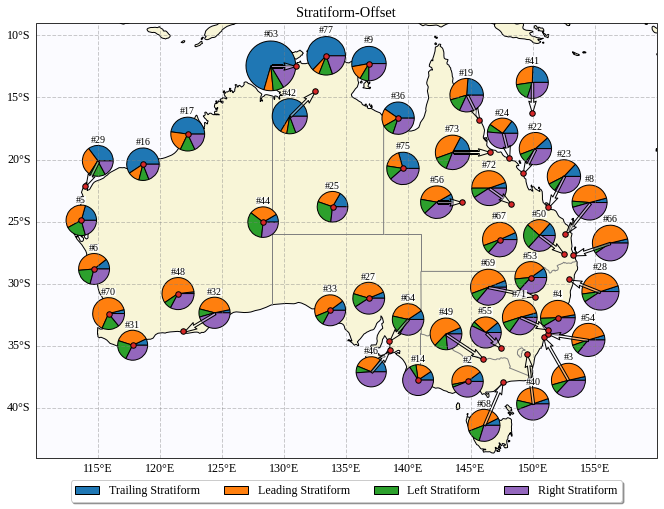

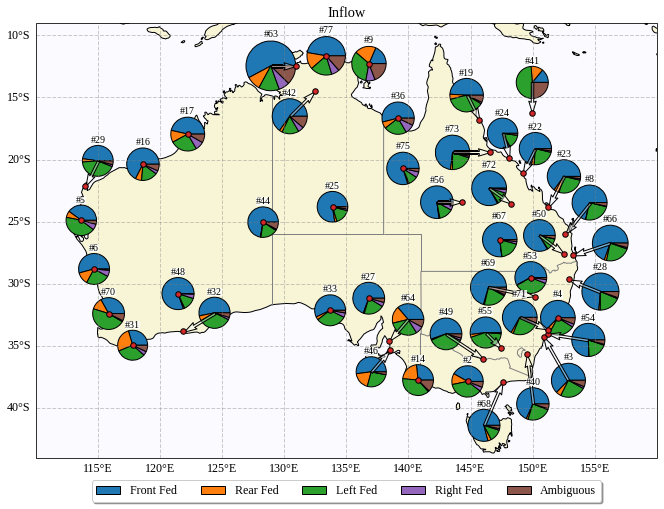

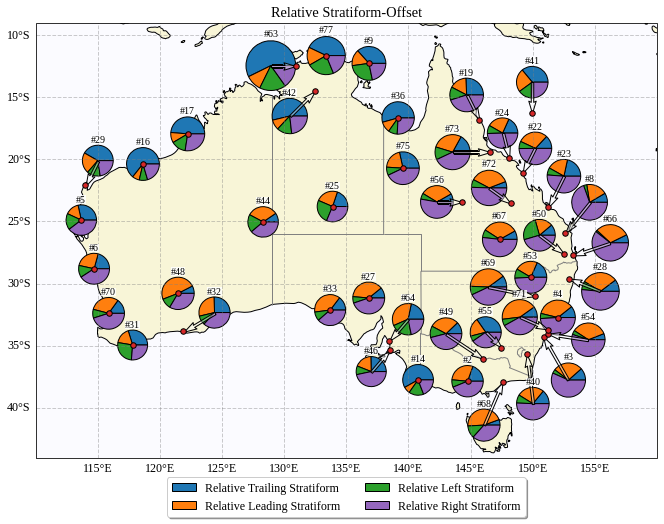

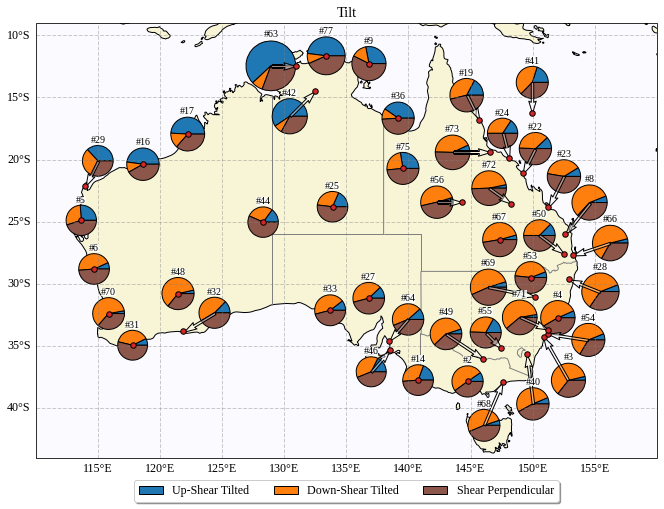

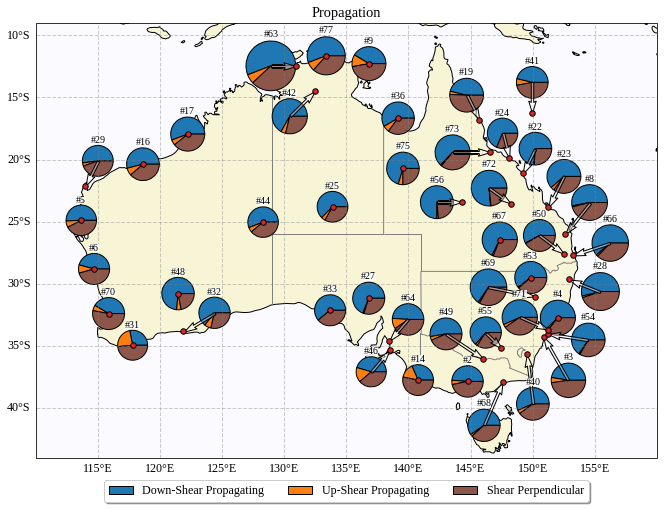

In [12]:
cl.plot_pie_map(radar_dfs)

base
ambient_swapped
lower_wind_level
higher_wind_level
no_steiner
lower_ref_thresh
higher_shear_thresh
higher_rel_vel_thresh
higher_theta_e
higher_offset_thresh
higher_border_thresh
higher_area_thresh
higher_conv_area_thresh
linear_50
linear_25
combined_sensitivity


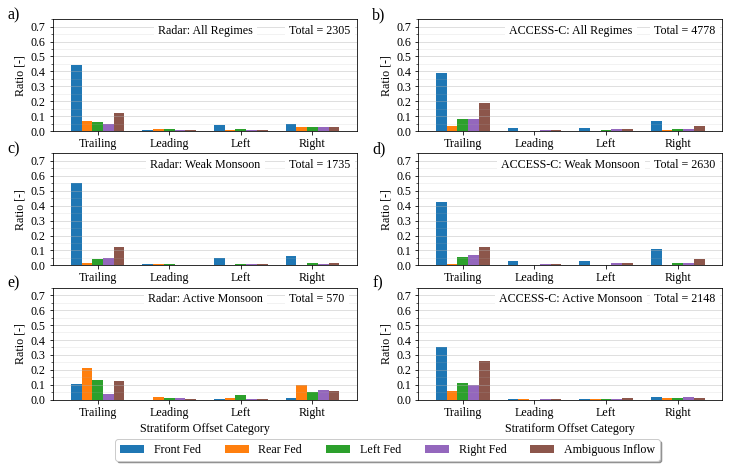

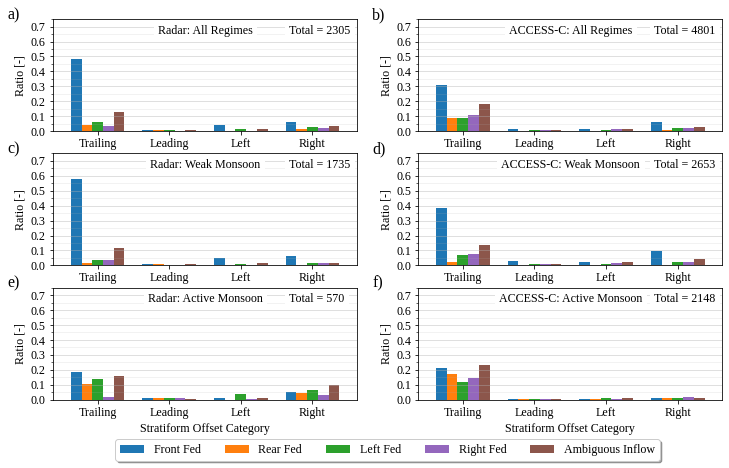

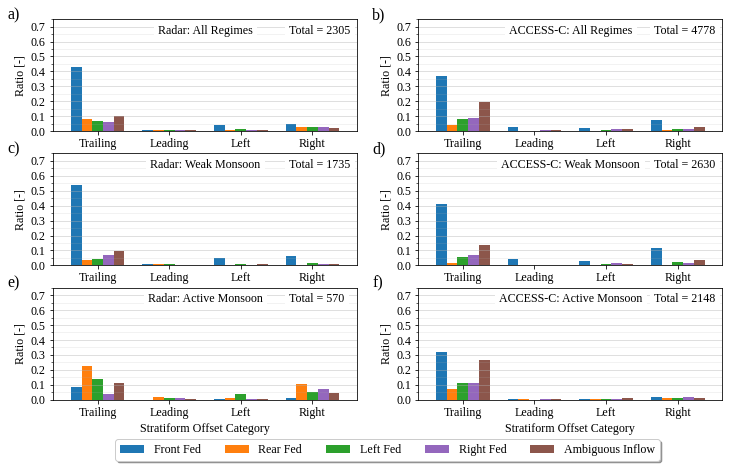

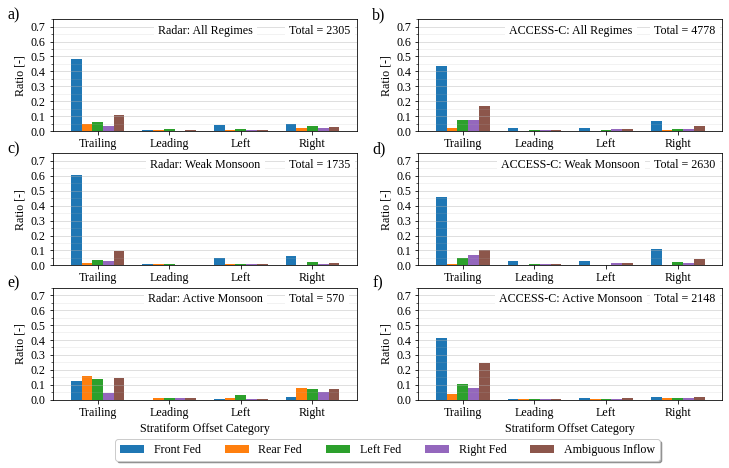

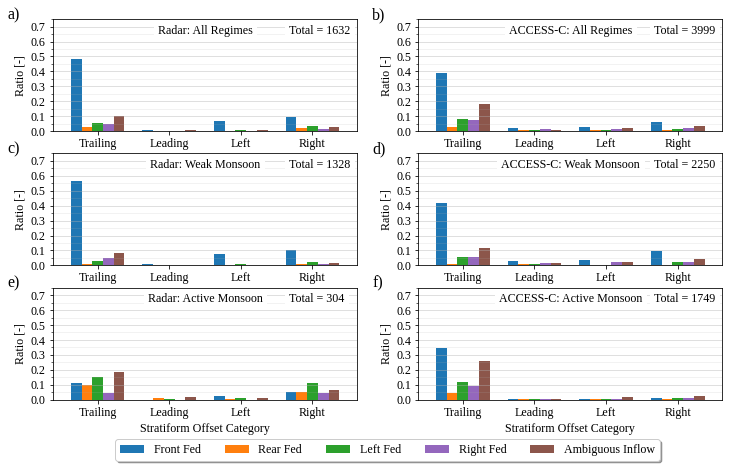

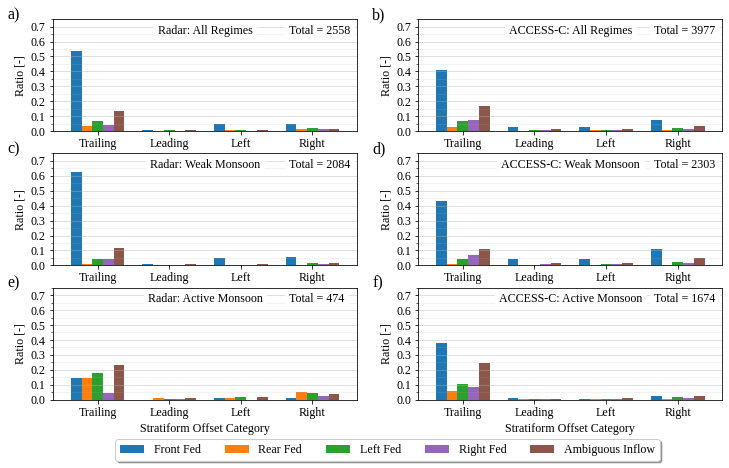

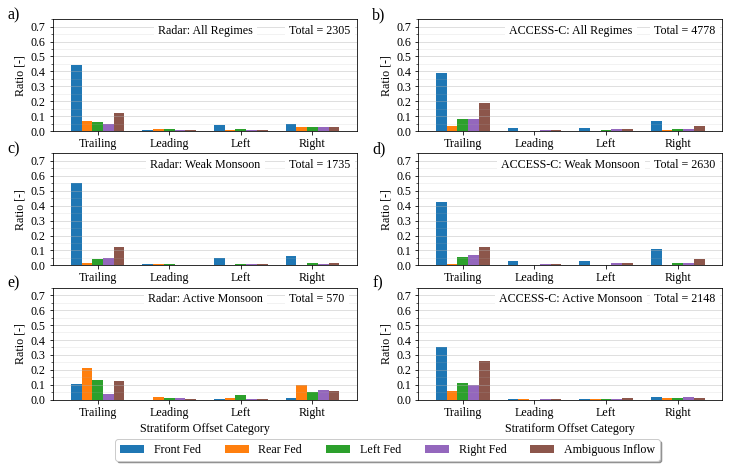

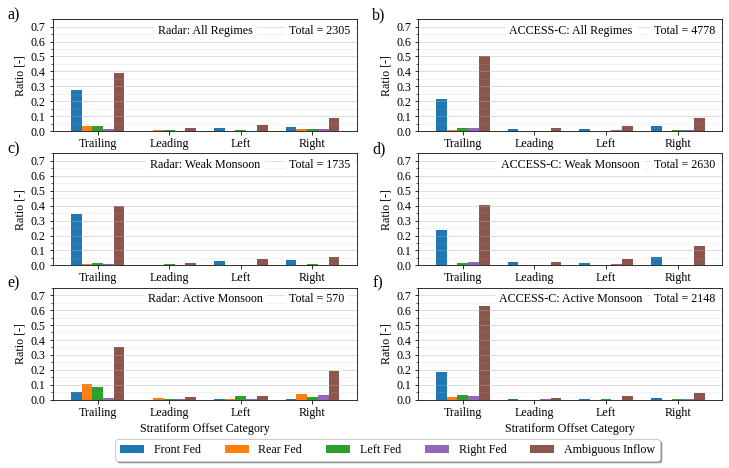

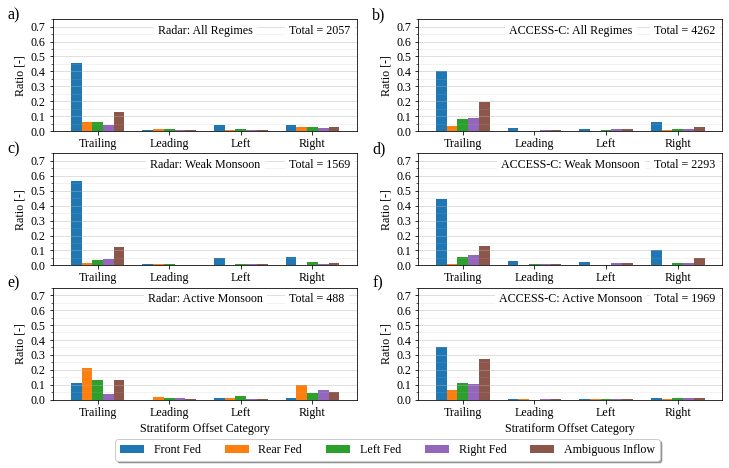

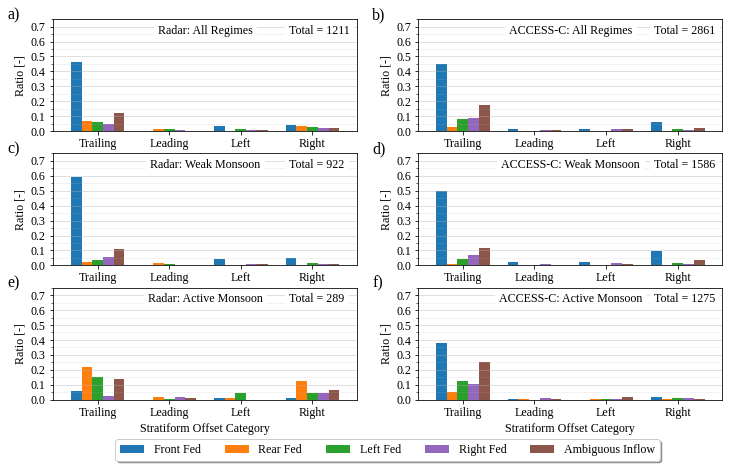

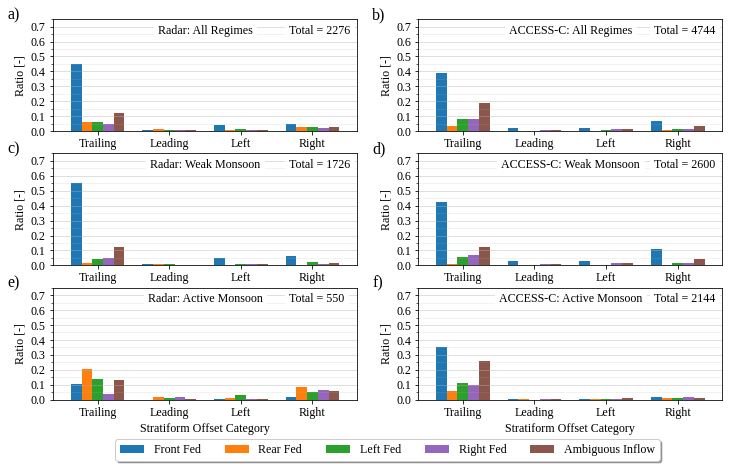

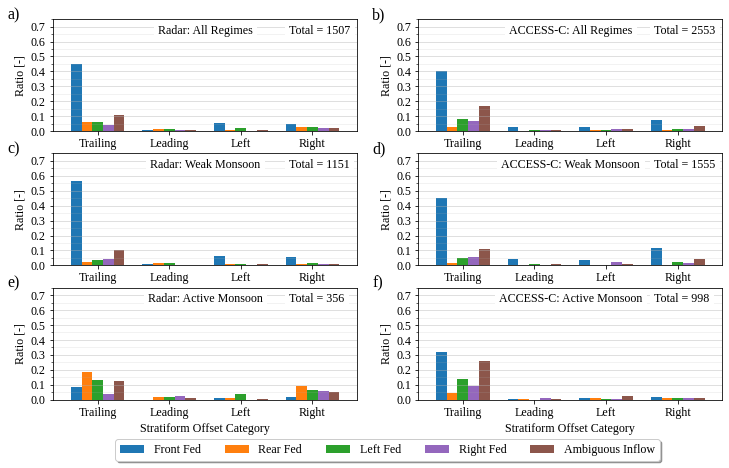

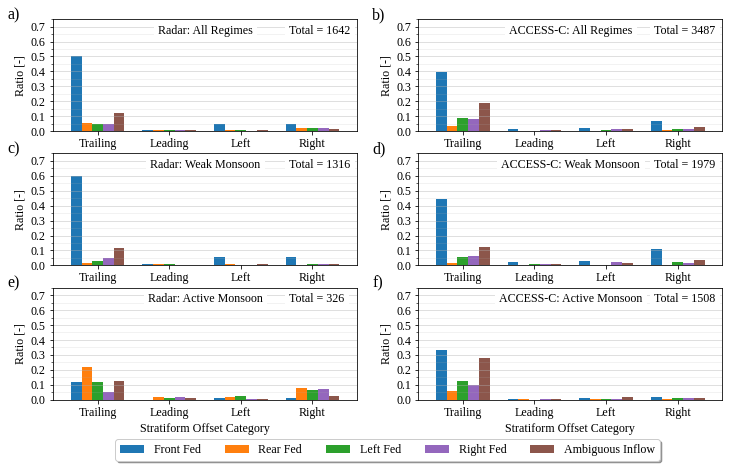

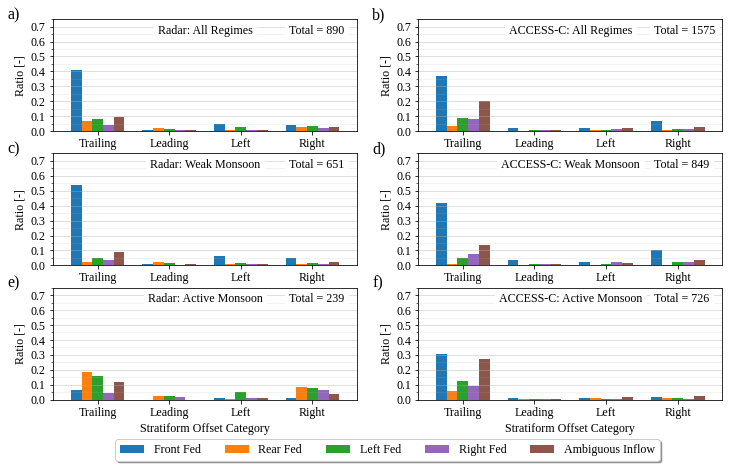

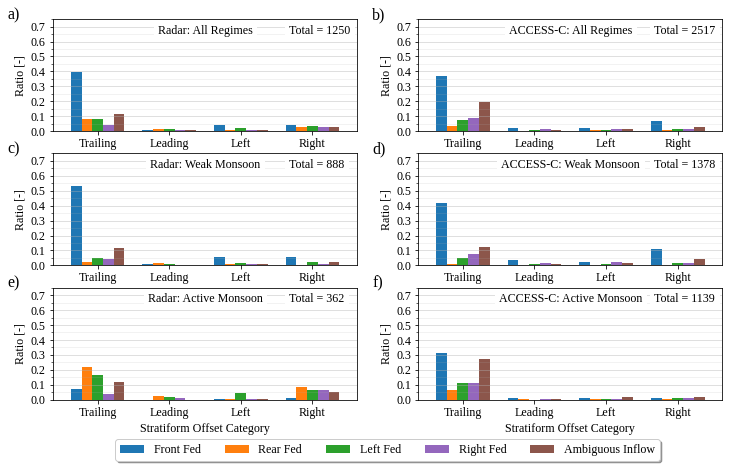

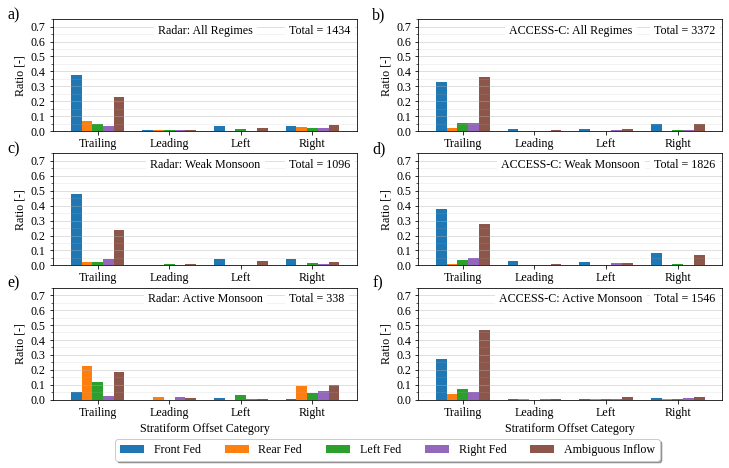

In [180]:
save_dir_base = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_'

test_names = [
    'base', 'ambient_swapped', 'lower_wind_level', 'higher_wind_level', 
    'no_steiner', 'lower_ref_thresh', 
    'higher_shear_thresh', 'higher_rel_vel_thresh', 
    'higher_theta_e', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'higher_conv_area_thresh', 'linear_50', 'linear_25', 
    'combined_sensitivity']


# test_names = ['base']

for tn in test_names:
    print(tn)
    cl.pope_comparison_radar(class_path=save_dir_base + tn + '/')

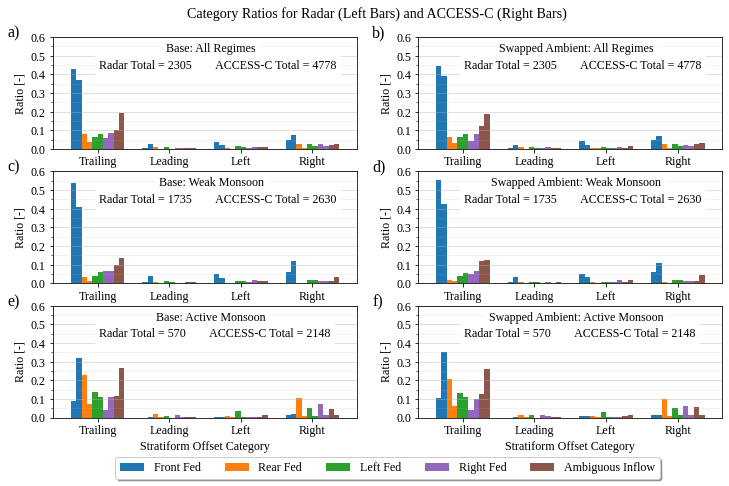

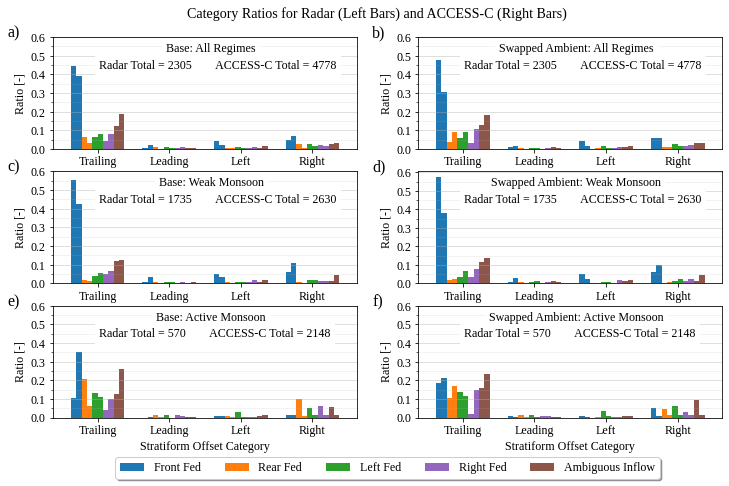

In [5]:
base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
class_path_2 = base_dir + 'TINT_tracks/ACCESS_radar_base/'
class_path_1 = base_dir + 'TINT_tracks/ACCESS_radar_lower_wind_level/'
cl.pope_comparison_radar_sensitivity(
    class_path_1=class_path_1, class_path_2=class_path_2)
cl.pope_comparison_radar_sensitivity()

In [285]:
base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
class_path = base_dir + 'TINT_tracks/ACCESS_radar_base/'
class_path += 'ACCESS_77/20211001_20220501.pkl'

with open(class_path, 'rb') as f:
    tracks_1 = pickle.load(f)
    
base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
class_path = base_dir + 'TINT_tracks/ACCESS_radar_ambient_swapped/'
class_path += 'ACCESS_77/20211001_20220501.pkl'

with open(class_path, 'rb') as f:
    tracks_2 = pickle.load(f)
    
times_1 = tracks_1.tracks.reset_index()['time'].values

In [286]:
tracks_2.tracks = tracks_2.tracks.loc[(slice(None), times_1, slice(None), slice(None))]
tracks_2.tracks_class = tracks_2.tracks_class.loc[(slice(None), times_1, slice(None), slice(None))]
tracks_2.exclusions = tracks_2.exclusions.loc[(slice(None), times_1, slice(None), slice(None))]
tracks_2.system_tracks = tracks_2.system_tracks.loc[(slice(None), times_1, slice(None))]

In [287]:
with open(class_path, 'wb') as f:
    pickle.dump(tracks_2, f)

In [246]:
test = [t in times_2 for t in times_1]
np.all(test)

True

In [211]:
base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
class_path = base_dir + 'TINT_tracks/ACCESS_radar_base/'
class_path += 'combined_ACCESS_classes.pkl'

with open(class_path, 'rb') as f:
    class_df_1 = pickle.load(f)
    
base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
class_path = base_dir + 'TINT_tracks/ACCESS_radar_ambient_swapped/'
class_path += 'combined_ACCESS_classes.pkl'

with open(class_path, 'rb') as f:
    class_df_2 = pickle.load(f)

In [215]:
class_df_2

offset_type  \
radar year uid  time                        
63    2020 1010 0      Leading Stratiform   
                150   Trailing Stratiform   
                160   Trailing Stratiform   
                170   Trailing Stratiform   
                180   Trailing Stratiform   
...                                   ...   
77    2021 990  0     Trailing Stratiform   
                10    Trailing Stratiform   
                30    Trailing Stratiform   
                40    Trailing Stratiform   
                50    Trailing Stratiform   

                                           rel_offset_type  \
radar year uid  time                                         
63    2020 1010 0     Relative Parallel Stratiform (Right)   
                150           Relative Trailing Stratiform   
                160           Relative Trailing Stratiform   
                170           Relative Trailing Stratiform   
                180      Ambiguous (Low Relative Velocity)   
...                                                    ...   
77    2021 990  0        Ambiguous (Low Relative Velocity)   
                10       Ambiguous (Low Relative Velocity)   
                30    Relative Parallel Stratiform (Right)   
                40    Relative Parallel Stratiform (Right)   
                50    Relative Parallel Stratiform (Right)   

                               inflow_type           tilt_dir  \
radar year uid  time                                            
63    2020 1010 0      Parallel Fed (Left)  Down-Shear Tilted   
                150              Front Fed    Up-Shear Tilted   
                160              Front Fed    Up-Shear Tilted   
                170              Front Fed    Up-Shear Tilted   
                180              Ambiguous    Up-Shear Tilted   
...                                    ...                ...   
77    2021 990  0                Ambiguous          Ambiguous   
                10               Ambiguous    Up-Shear Tilted   
                30    Parallel Fed (Right)          Ambiguous   
                40    Parallel Fed (Right)          Ambiguous   
                50    Parallel Fed (Right)          Ambiguous   

                                    prop_dir  pope_regime  
radar year uid  time                                       
63    2020 1010 0        Perpendicular Shear            1  
                150   Down-Shear Propagating            1  
                160   Down-Shear Propagating            1  
                170   Down-Shear Propagating            1  
                180                Ambiguous            1  
...                                      ...          ...  
77    2021 990  0                  Ambiguous            1  
                10                 Ambiguous            1  
                30                 Ambiguous            1  
                40                 Ambiguous            1  
                50                 Ambiguous            1  

[4801 rows x 6 columns]

In [20]:
counts_df = pd.DataFrame({'count': class_df.value_counts()})
counts_df = counts_df.reset_index('pope_regime')

pope = counts_df['pope_regime'].values
pope_dic = {0: 'Not Classified'}
for i in range(1, 6):
    pope_dic[i] = 'Inactive Monsoon'
pope_dic[2] = 'Active Monsoon'
monsoon = [pope_dic[p_num] for p_num in pope]
counts_df['pope_regime'] = monsoon

counts_df = counts_df[counts_df['pope_regime'] == 'Inactive Monsoon']
# counts_df = counts_df[counts_df['offset_type'] == 'Trailing Stratiform']

counts_df = counts_df.groupby(
    ['offset_type', 'inflow_type', 'tilt_dir', 'prop_dir']).sum()

counts_df = counts_df.drop('Ambiguous', level='inflow_type')
counts_df = counts_df.drop('Perpendicular Shear', level='tilt_dir')
counts_df = counts_df.drop('Ambiguous', level='tilt_dir')
counts_df = counts_df.drop('Perpendicular Shear', level='prop_dir')
counts_df = counts_df.drop('Ambiguous', level='prop_dir')

total_ratio = (counts_df['count']/counts_df['count'].sum())
counts_df['total_ratio'] = total_ratio

In [21]:
counts_df.sort_values('count', axis=0, ascending=False)

count  \
offset_type                 inflow_type          tilt_dir          prop_dir                        
Trailing Stratiform         Front Fed            Up-Shear Tilted   Down-Shear Propagating    289   
                                                 Down-Shear Tilted Up-Shear Propagating       95   
Leading Stratiform          Front Fed            Down-Shear Tilted Down-Shear Propagating     27   
Parallel Stratiform (Left)  Parallel Fed (Right) Down-Shear Tilted Up-Shear Propagating       16   
Trailing Stratiform         Parallel Fed (Left)  Up-Shear Tilted   Up-Shear Propagating       11   
Parallel Stratiform (Right) Front Fed            Up-Shear Tilted   Down-Shear Propagating      6   
Trailing Stratiform         Rear Fed             Up-Shear Tilted   Up-Shear Propagating        6   
Parallel Stratiform (Right) Parallel Fed (Right) Up-Shear Tilted   Up-Shear Propagating        5   
Trailing Stratiform         Parallel Fed (Left)  Up-Shear Tilted   Down-Shear Propagating      5   
                            Parallel Fed (Right) Down-Shear Tilted Up-Shear Propagating        5   
Parallel Stratiform (Right) Parallel Fed (Right) Down-Shear Tilted Down-Shear Propagating      4   
Leading Stratiform          Parallel Fed (Left)  Down-Shear Tilted Down-Shear Propagating      3   
Trailing Stratiform         Parallel Fed (Right) Up-Shear Tilted   Up-Shear Propagating        3   
Parallel Stratiform (Right) Rear Fed             Up-Shear Tilted   Up-Shear Propagating        3   
                            Parallel Fed (Left)  Up-Shear Tilted   Down-Shear Propagating      1   
                            Front Fed            Down-Shear Tilted Up-Shear Propagating        1   
Parallel Stratiform (Left)  Rear Fed             Down-Shear Tilted Down-Shear Propagating      1   
Trailing Stratiform         Parallel Fed (Left)  Down-Shear Tilted Down-Shear Propagating      1   
Parallel Stratiform (Left)  Front Fed            Down-Shear Tilted Down-Shear Propagating      1   
Trailing Stratiform         Parallel Fed (Right) Up-Shear Tilted   Down-Shear Propagating      1   

                                                                                           total_ratio  
offset_type                 inflow_type          tilt_dir          prop_dir                             
Trailing Stratiform         Front Fed            Up-Shear Tilted   Down-Shear Propagating     0.597107  
                                                 Down-Shear Tilted Up-Shear Propagating       0.196281  
Leading Stratiform          Front Fed            Down-Shear Tilted Down-Shear Propagating     0.055785  
Parallel Stratiform (Left)  Parallel Fed (Right) Down-Shear Tilted Up-Shear Propagating       0.033058  
Trailing Stratiform         Parallel Fed (Left)  Up-Shear Tilted   Up-Shear Propagating       0.022727  
Parallel Stratiform (Right) Front Fed            Up-Shear Tilted   Down-Shear Propagating     0.012397  
Trailing Stratiform         Rear Fed             Up-Shear Tilted   Up-Shear Propagating       0.012397  
Parallel Stratiform (Right) Parallel Fed (Right) Up-Shear Tilted   Up-Shear Propagating       0.010331  
Trailing Stratiform         Parallel Fed (Left)  Up-Shear Tilted   Down-Shear Propagating     0.010331  
                            Parallel Fed (Right) Down-Shear Tilted Up-Shear Propagating       0.010331  
Parallel Stratiform (Right) Parallel Fed (Right) Down-Shear Tilted Down-Shear Propagating     0.008264  
Leading Stratiform          Parallel Fed (Left)  Down-Shear Tilted Down-Shear Propagating     0.006198  
Trailing Stratiform         Parallel Fed (Right) Up-Shear Tilted   Up-Shear Propagating       0.006198  
Parallel Stratiform (Right) Rear Fed             Up-Shear Tilted   Up-Shear Propagating       0.006198  
                            Parallel Fed (Left)  Up-Shear Tilted   Down-Shear Propagating     0.002066  
                            Front Fed            Down-Shear Tilted Up-Shear Propagating       0.002066  


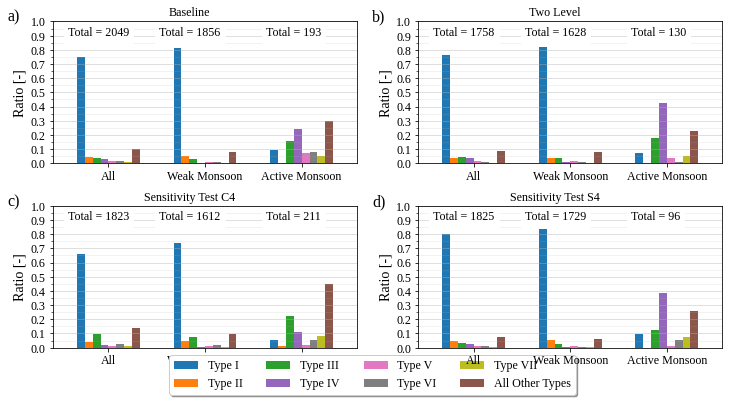

In [331]:
test_names = [
    'base', 'lower_conv_level', 'higher_conv_level', 'two_levels', 
    'four_levels',
    'no_steiner', 'lower_ref_thresh', 'higher_shear_thresh', 
    'higher_rel_vel_thresh', 
    'higher_theta_e', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'linear_50', 'linear_25', 'combined', 'morning_only']

# test_names = [
#     'base', 'lower_conv_level', 
#     'higher_conv_level', 'higher_shear_thresh']

# titles = [
#     'Baseline', 'Sensitivity Test C2', 'Sensitivity Test C4',
#     'Sensitivity Test S4']

test_names = [
    'base', 'two_levels', 
    'higher_conv_level', 'higher_shear_thresh']

titles = [
    'Baseline', 'Two Level',
    'Sensitivity Test C4',
    'Sensitivity Test S4']

fig, axes = plt.subplots(
    int(np.ceil(len(test_names)/2)), 2, figsize=(12, 6))

for i in range(len(test_names)):
# for i in [3]:

    base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
    class_path = base_dir + 'TINT_tracks/'
    class_path += '{}_classes.pkl'.format(test_names[i])

    with open(class_path, 'rb') as f:
        class_df = pickle.load(f)

    ratios_df = cl.monsoon_comparison(
        class_df, fig=fig, ax=axes.flatten()[i], legend=False, 
        title=titles[i])
            
#     fn = 'shear_breakdown_{}.png'.format(test_names[i])
#     plt.savefig(
#         fig_dir + fn, dpi=200, facecolor='w',
#         edgecolor='white', bbox_inches='tight')

axes.flatten()[-2].legend(
    loc='lower center', bbox_to_anchor=(1.05, -0.375),
    ncol=4, fancybox=True, shadow=True)

cl.make_subplot_labels(axes.flatten())

plt.subplots_adjust(hspace=0.3)

fn = 'monsoon_breakdown_base_lower_higher_lvl_higher_shear_two_level.png'.format(test_names[i])
plt.savefig(
    fig_dir + fn, dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

In [353]:
base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
class_path = base_dir + 'TINT_tracks/ACCESS_radar_higher_offset_thresh/'
class_path += 'combined_radar_classes.pkl'

with open(class_path, 'rb') as f:
    class_df = pickle.load(f)
    
counts_df = pd.DataFrame({'count': class_df.value_counts()})
counts_df = counts_df.reset_index('pope_regime')

pope = counts_df['pope_regime'].values
pope_dic = {0: 'Not Classified'}
for i in range(1, 6):
    pope_dic[i] = 'Inactive Monsoon'
pope_dic[2] = 'Active Monsoon'
monsoon = [pope_dic[p_num] for p_num in pope]
counts_df['pope_regime'] = monsoon

# counts_df = counts_df[counts_df['pope_regime'] == 'Inactive Monsoon']
# counts_df = counts_df[counts_df['offset_type'] == 'Trailing Stratiform']

counts_df = counts_df.groupby(
    ['offset_type', 'inflow_type', 'tilt_dir', 'prop_dir']).sum()

counts_df = counts_df.drop('Ambiguous', level='inflow_type')
counts_df = counts_df.drop('Perpendicular Shear', level='tilt_dir')
counts_df = counts_df.drop('Ambiguous', level='tilt_dir')
counts_df = counts_df.drop('Perpendicular Shear', level='prop_dir')
counts_df = counts_df.drop('Ambiguous', level='prop_dir')

total_ratio = (counts_df['count']/counts_df['count'].sum())
counts_df['total_ratio'] = total_ratio

counts_df.sort_values('count', axis=0, ascending=False)

count  \
offset_type                 inflow_type          tilt_dir          prop_dir                        
Trailing Stratiform         Front Fed            Up-Shear Tilted   Down-Shear Propagating    315   
                            Rear Fed             Up-Shear Tilted   Up-Shear Propagating       10   
Parallel Stratiform (Right) Parallel Fed (Right) Up-Shear Tilted   Up-Shear Propagating        7   
Leading Stratiform          Rear Fed             Down-Shear Tilted Up-Shear Propagating        7   
Parallel Stratiform (Right) Parallel Fed (Left)  Up-Shear Tilted   Down-Shear Propagating      5   
Trailing Stratiform         Parallel Fed (Right) Up-Shear Tilted   Down-Shear Propagating      5   
                            Front Fed            Down-Shear Tilted Up-Shear Propagating        4   
Parallel Stratiform (Right) Rear Fed             Down-Shear Tilted Down-Shear Propagating      3   
                                                 Up-Shear Tilted   Down-Shear Propagating      3   
Trailing Stratiform         Rear Fed             Down-Shear Tilted Down-Shear Propagating      2   
Parallel Stratiform (Right) Parallel Fed (Left)  Down-Shear Tilted Up-Shear Propagating        2   
Trailing Stratiform         Parallel Fed (Left)  Down-Shear Tilted Up-Shear Propagating        2   
                                                 Up-Shear Tilted   Down-Shear Propagating      2   
                                                                   Up-Shear Propagating        2   
                            Parallel Fed (Right) Down-Shear Tilted Up-Shear Propagating        1   
                                                 Up-Shear Tilted   Up-Shear Propagating        1   
Leading Stratiform          Front Fed            Down-Shear Tilted Down-Shear Propagating      1   
Parallel Stratiform (Right) Parallel Fed (Right) Down-Shear Tilted Down-Shear Propagating      1   
                            Front Fed            Up-Shear Tilted   Down-Shear Propagating      1   
Leading Stratiform          Rear Fed             Up-Shear Tilted   Down-Shear Propagating      1   
Parallel Stratiform (Right) Rear Fed             Up-Shear Tilted   Up-Shear Propagating        1   

                                                                                           total_ratio  
offset_type                 inflow_type          tilt_dir          prop_dir                             
Trailing Stratiform         Front Fed            Up-Shear Tilted   Down-Shear Propagating     0.837766  
                            Rear Fed             Up-Shear Tilted   Up-Shear Propagating       0.026596  
Parallel Stratiform (Right) Parallel Fed (Right) Up-Shear Tilted   Up-Shear Propagating       0.018617  
Leading Stratiform          Rear Fed             Down-Shear Tilted Up-Shear Propagating       0.018617  
Parallel Stratiform (Right) Parallel Fed (Left)  Up-Shear Tilted   Down-Shear Propagating     0.013298  
Trailing Stratiform         Parallel Fed (Right) Up-Shear Tilted   Down-Shear Propagating     0.013298  
                            Front Fed            Down-Shear Tilted Up-Shear Propagating       0.010638  
Parallel Stratiform (Right) Rear Fed             Down-Shear Tilted Down-Shear Propagating     0.007979  
                                                 Up-Shear Tilted   Down-Shear Propagating     0.007979  
Trailing Stratiform         Rear Fed             Down-Shear Tilted Down-Shear Propagating     0.005319  
Parallel Stratiform (Right) Parallel Fed (Left)  Down-Shear Tilted Up-Shear Propagating       0.005319  
Trailing Stratiform         Parallel Fed (Left)  Down-Shear Tilted Up-Shear Propagating       0.005319  
                                                 Up-Shear Tilted   Down-Shear Propagating     0.005319  
                                                                   Up-Shear Propagating       0.005319  
                            Parallel Fed (Right) Down-Shear Tilted Up-Shear Propagating       0.002660  
     

No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.


/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2944: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclass

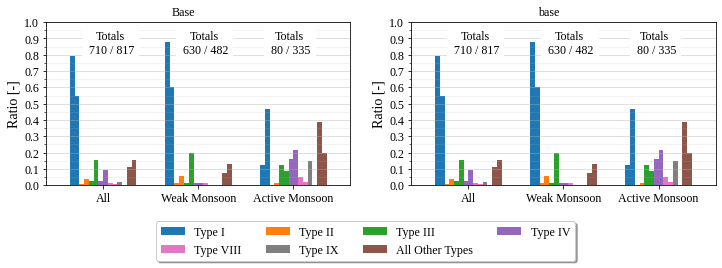

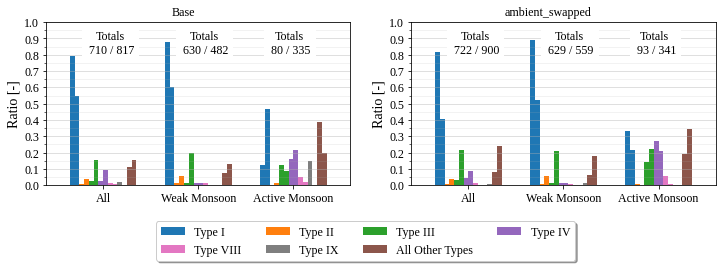

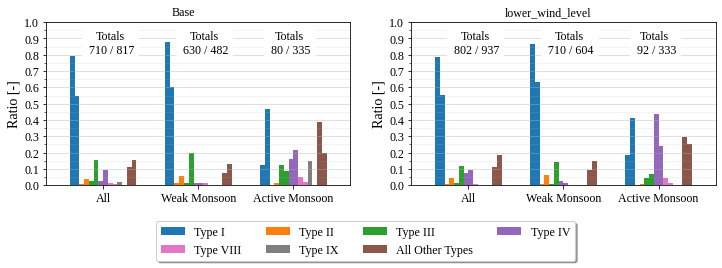

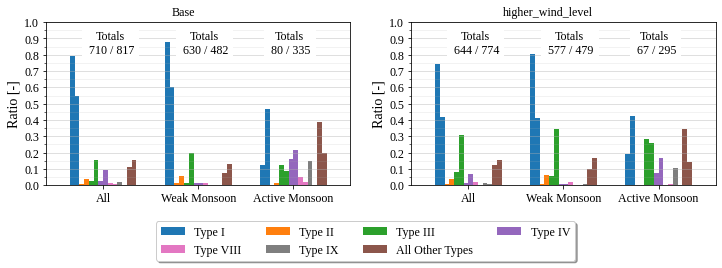

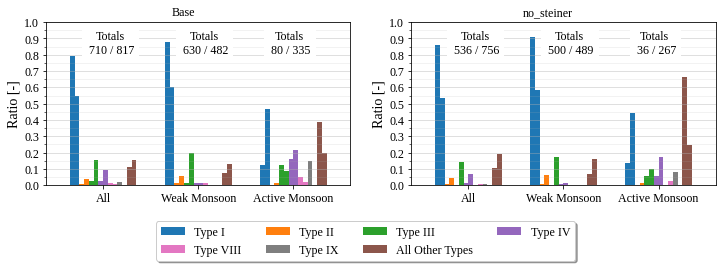

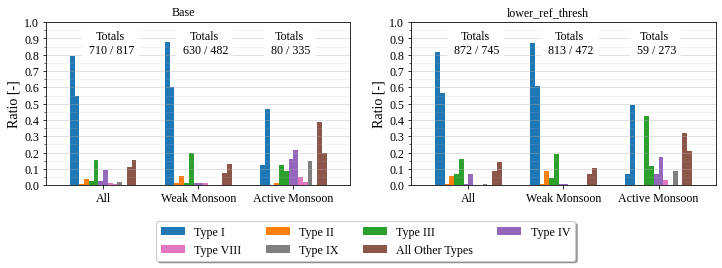

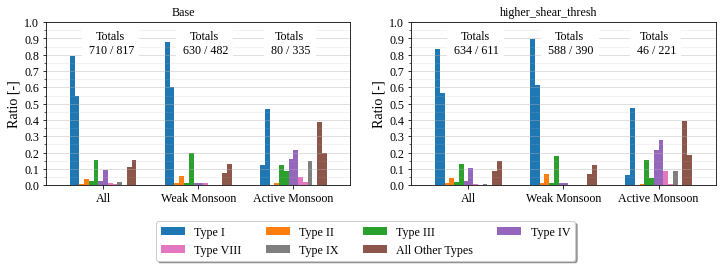

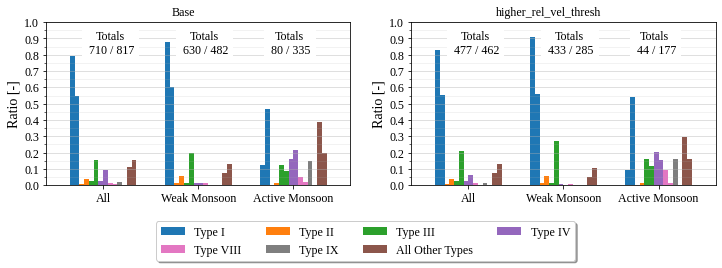

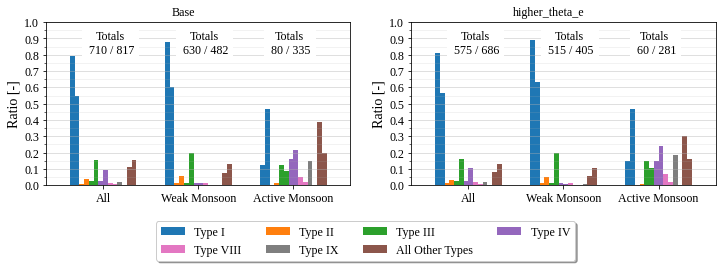

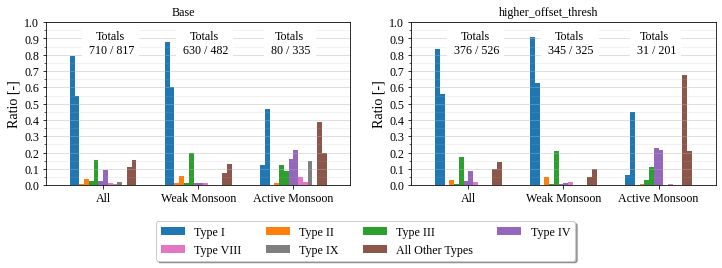

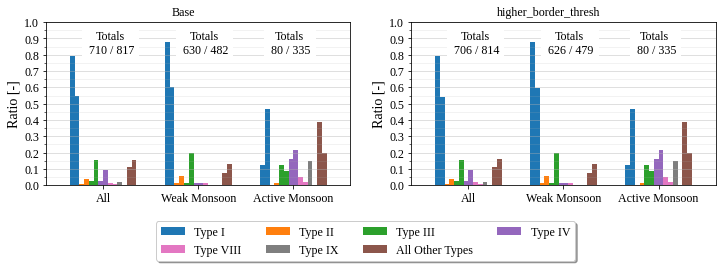

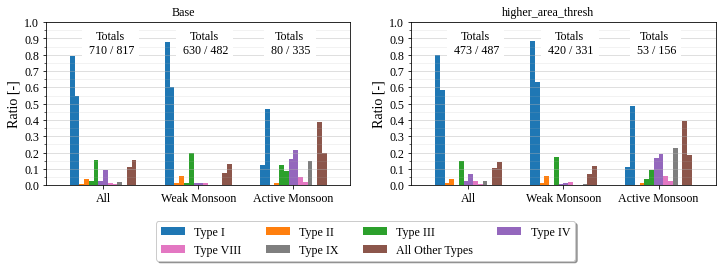

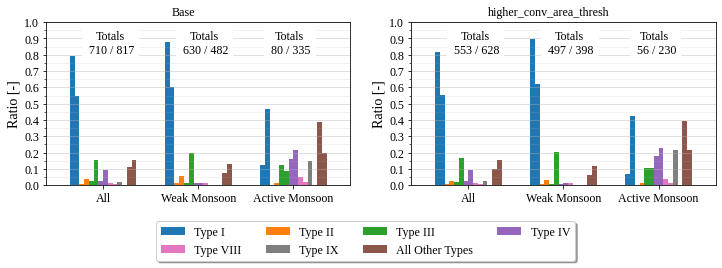

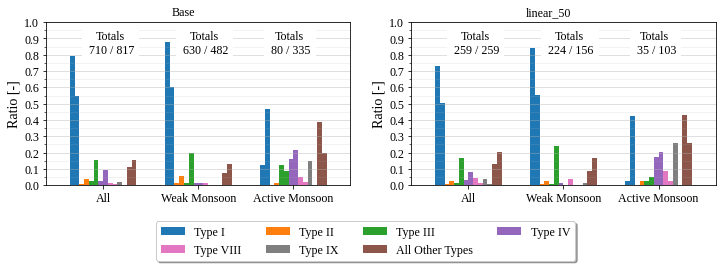

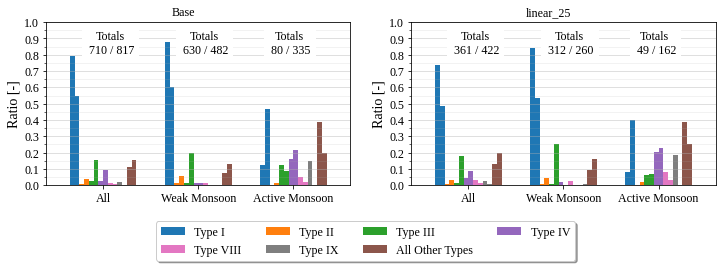

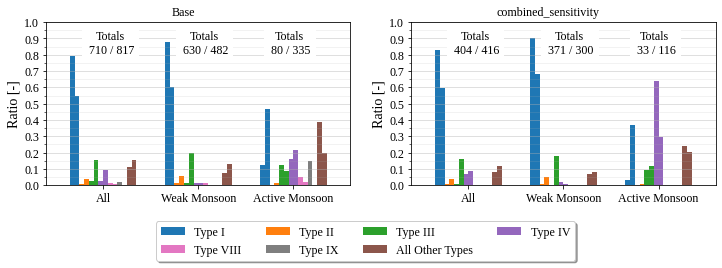

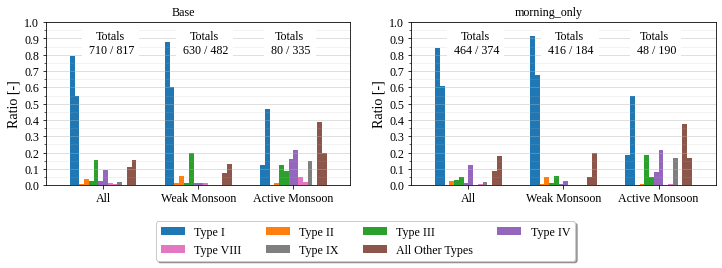

In [11]:
test_names = [
    'base', 'ambient_swapped', 'lower_wind_level', 'higher_wind_level', 
    'no_steiner', 'lower_ref_thresh', 
    'higher_shear_thresh', 'higher_rel_vel_thresh', 
    'higher_theta_e', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'higher_conv_area_thresh', 'linear_50', 'linear_25', 
    'combined_sensitivity', 'morning_only']

for tn in test_names:

    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    # plot base
    base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
    class_path = base_dir + 'TINT_tracks/ACCESS_radar_base/'.format(tn)
    class_path += 'combined_radar_classes.pkl'

    with open(class_path, 'rb') as f:
        class_df_1 = pickle.load(f)

    base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
    class_path = base_dir + 'TINT_tracks/ACCESS_radar_base/'.format(tn)
    class_path += 'combined_ACCESS_classes.pkl'

    with open(class_path, 'rb') as f:
        class_df_2 = pickle.load(f)

    ratios_df = cl.monsoon_comparison_ACCESS_radar(
        class_df_1=class_df_1, class_df_2=class_df_2, 
        fig=fig, ax=axes[0], legend=False, 
        title='Base')

    # plot sensitivity example
    base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
    class_path = base_dir + 'TINT_tracks/ACCESS_radar_{}/'.format(tn)
    class_path += 'combined_radar_classes.pkl'

    with open(class_path, 'rb') as f:
        class_df_1 = pickle.load(f)

    base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
    class_path = base_dir + 'TINT_tracks/ACCESS_radar_{}/'.format(tn)
    class_path += 'combined_ACCESS_classes.pkl'

    with open(class_path, 'rb') as f:
        class_df_2 = pickle.load(f)

    ratios_df = cl.monsoon_comparison_ACCESS_radar(
        class_df_1=class_df_1, class_df_2=class_df_2, 
        fig=fig, ax=axes[1], legend=False, 
        title=tn)
    
    lines, labels = axes.flatten()[-2].get_legend_handles_labels()
    col_names = [
        'Type I', 'Type II', 'Type III', 'Type IV', 'Type VIII', 
        'Type IX', 'All Other Types']
    lines = lines[::2]

    lines = [lines[i] for i in [0, 4, 1, 5, 2, 6, 3]]
    col_names = [col_names[i] for i in [0, 4, 1, 5, 2, 6, 3]]

    axes.flatten()[-2].legend(
        lines, col_names,
        loc='lower center', bbox_to_anchor=(1.05, -0.5),
        ncol=4, fancybox=True, shadow=True)
    
    plt.savefig(
        fig_dir + 'monsoon_breakdown_sensitivity_{}.png'.format(tn),
        dpi=200, facecolor='w',
        edgecolor='white', bbox_inches='tight')

No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.
No unclassified regime cases.


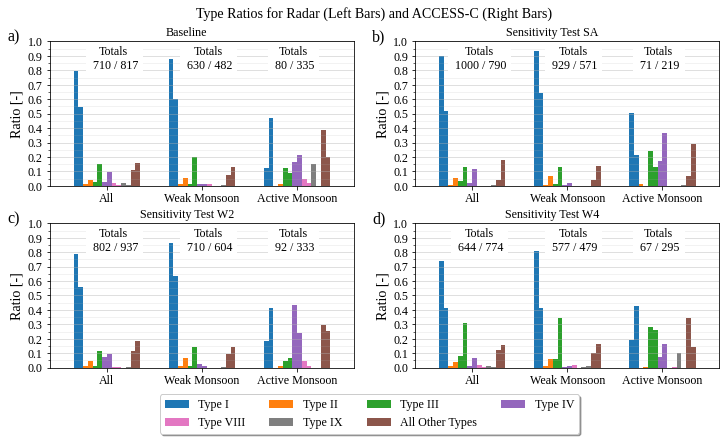

In [30]:
test_names = [
    'base', 'ambient_swapped', 'lower_wind_level', 'higher_wind_level', 
    'no_steiner', 'lower_ref_thresh', 
    'higher_shear_thresh', 'higher_rel_vel_thresh', 
    'higher_theta_e', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'higher_conv_area_thresh', 'linear_50', 'linear_25', 
    'combined_sensitivity']

test_names = [
    'base', 'ambient_swapped_lower_wind_level', 'lower_wind_level', 'higher_wind_level']
titles = [
    'Baseline', 'Sensitivity Test SA', 
    'Sensitivity Test W2', 'Sensitivity Test W4']

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for i in range(len(test_names)):

    tn = test_names[i]

    # plot sensitivity example
    base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
    class_path = base_dir + 'TINT_tracks/ACCESS_radar_{}/'.format(tn)
    class_path += 'combined_radar_classes.pkl'

    with open(class_path, 'rb') as f:
        class_df_1 = pickle.load(f)

    base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
    class_path = base_dir + 'TINT_tracks/ACCESS_radar_{}/'.format(tn)
    class_path += 'combined_ACCESS_classes.pkl'

    with open(class_path, 'rb') as f:
        class_df_2 = pickle.load(f)

    ratios_df = cl.monsoon_comparison_ACCESS_radar(
        class_df_1=class_df_1, class_df_2=class_df_2, 
        fig=fig, ax=axes.flatten()[i], legend=False, 
        title=titles[i])
    
lines, labels = axes.flatten()[-2].get_legend_handles_labels()
col_names = [
    'Type I', 'Type II', 'Type III', 'Type IV', 'Type VIII', 
    'Type IX', 'All Other Types']
lines = lines[::2]

lines = [lines[i] for i in [0, 4, 1, 5, 2, 6, 3]]
col_names = [col_names[i] for i in [0, 4, 1, 5, 2, 6, 3]]

axes.flatten()[-2].legend(
    lines, col_names,
    loc='lower center', bbox_to_anchor=(1.05, -0.5),
    ncol=4, fancybox=True, shadow=True)

plt.suptitle(
    'Type Ratios for Radar (Left Bars) and ACCESS-C (Right Bars)',
    fontsize=14, y=.96)

plt.subplots_adjust(hspace=0.26)
cl.make_subplot_labels(axes.flatten(), x_shift=-.14)

plt.savefig(
    fig_dir + 'monsoon_breakdown_sensitivity_ACCESS_radar.png'.format(tn),
    dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')